# introduction

This file tests the **load forecasting** for the [Global Energy Forecasting Competition 2012 - Load Forecasting](https://www.kaggle.com/competitions/global-energy-forecasting-competition-2012-load-forecasting/overview).

`Goal`: 

- backcasting and forecasting hourly loads (in kW) for a US utility with 20 zones, plus an additional system level (sum of the 20 zonal level series), totally 21 series.
- to forecast forecast hourly loads from 2008/7/1 to 2008/7/7 where no actual temperatures are given for this week.
- to backcast the 8 weeks of missing data.

`Note`:

- temperature available as one co-variate.
- missing data in `load_history.csv` which required to be backcasted.

`Data`:

- each row represents a day.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from energy_forecasting.modules import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
load = pd.read_csv('../data/raw/GEF2012_load_forecasting/Load_history.csv',  thousands=',')

In [5]:
load = change_timeindex(load)

In [6]:
# which zone
load_zone1 = get_series_by_zone(df=load, identifier='zone_id', id=1)

In [7]:
load_zone1.tail()

2008-07-07 19:00:00   NaN
2008-07-07 20:00:00   NaN
2008-07-07 21:00:00   NaN
2008-07-07 22:00:00   NaN
2008-07-07 23:00:00   NaN
Freq: H, dtype: float32

In [8]:
len(load_zone1)

39600

In [9]:
temperature = pd.read_csv('../data/raw/GEF2012_load_forecasting/temperature_history.csv')

In [10]:
temperature = change_timeindex(temperature)

In [11]:
# temperature.head()

In [12]:
# which zone
temp_zone1 = get_series_by_zone(df=temperature, identifier='station_id', id=1)

In [13]:
len(temp_zone1)

39432

In [14]:
temp_zone1.index[-1]

Timestamp('2008-06-30 23:00:00')

In [15]:
load_zone1.index[-1]

Timestamp('2008-07-07 23:00:00')

In [16]:
# at least they need to be of same length



In [17]:
tail_timeindex = pd.date_range(start = temp_zone1.index[-1], end = load_zone1.index[-1], freq='H', inclusive='right')

In [18]:
tail_timeindex

DatetimeIndex(['2008-07-01 00:00:00', '2008-07-01 01:00:00',
               '2008-07-01 02:00:00', '2008-07-01 03:00:00',
               '2008-07-01 04:00:00', '2008-07-01 05:00:00',
               '2008-07-01 06:00:00', '2008-07-01 07:00:00',
               '2008-07-01 08:00:00', '2008-07-01 09:00:00',
               ...
               '2008-07-07 14:00:00', '2008-07-07 15:00:00',
               '2008-07-07 16:00:00', '2008-07-07 17:00:00',
               '2008-07-07 18:00:00', '2008-07-07 19:00:00',
               '2008-07-07 20:00:00', '2008-07-07 21:00:00',
               '2008-07-07 22:00:00', '2008-07-07 23:00:00'],
              dtype='datetime64[ns]', length=168, freq='H')

In [19]:
len(tail_timeindex)

168

In [20]:
tail_series = pd.Series(data = np.nan, index=tail_timeindex)

In [21]:
full_temp_zone1 = pd.concat([temp_zone1, tail_series])

In [22]:
len(full_temp_zone1)

39600

In [23]:
# now that we have training data at hand
# temperature_zone_1 --> load_zone_1

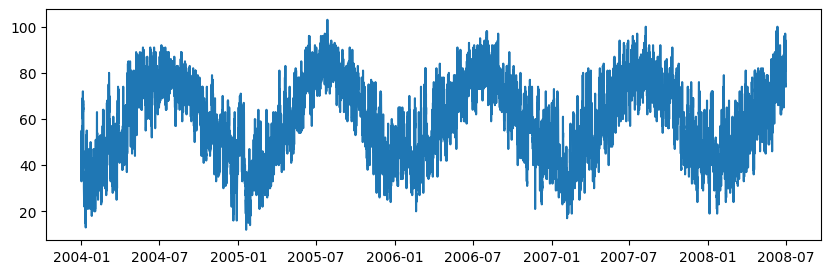

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(full_temp_zone1)
# ax.plot(load_zone1)

In [25]:
np.sum(full_temp_zone1.isna())

186

In [26]:
np.sum(load_zone1.isna())

1530

In [27]:
len(full_temp_zone1)

39600

## the missing data

for now, simply just discard the missing data

In [28]:
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller

In [29]:
filler_load = MissingValuesFiller()

In [30]:
filler_temp = MissingValuesFiller()

In [31]:
load_filled = filler_load.transform(TimeSeries.from_series(load_zone1))

In [32]:
temp_filled = filler_temp.transform(TimeSeries.from_series(full_temp_zone1))

<Axes: xlabel='time'>

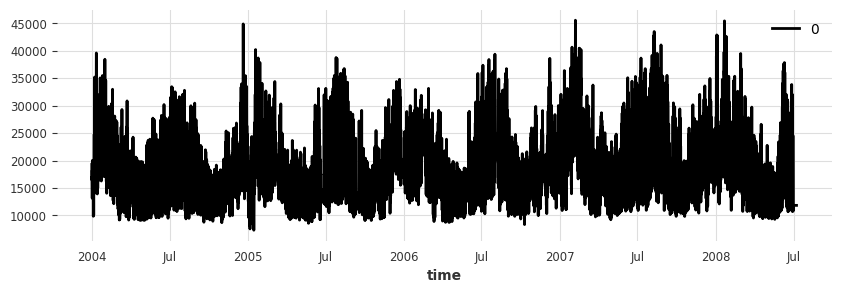

In [33]:
plt.figure(figsize=(10, 3))
load_filled.plot()

# modelling

now that we've finally got the data of `target`: load_filled, `covariate`: temp_filled. Let's model!

In [34]:
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape

In [35]:
# define train/validation cutoff time
forecast_horizon_ice = 48
training_cutoff_ice = load_filled.time_index[-(2 * forecast_horizon_ice)]

In [36]:
training_cutoff_ice

Timestamp('2008-07-04 00:00:00')

In [37]:
# target

train_load, val_load = load_filled.split_before(training_cutoff_ice)

scaler_load = Scaler()
train_load_transformed = scaler_load.fit_transform(train_load)
val_load_transformed = scaler_load.transform(val_load)

load_all_transformed = scaler_load.transform(load_filled)

In [38]:
# check the data type
train_load_transformed.dtype

dtype('float32')

In [39]:
# use heater sales as past covariates and transform data

cov_temp_train, cov_temp_val = temp_filled.split_before(training_cutoff_ice)

scaler_temp = Scaler()
scaler_temp.fit(cov_temp_train)

covariates_temp_transformed = scaler_temp.transform(temp_filled)
covariates_temp_transformed = covariates_temp_transformed.astype('float32')

In [40]:
covariates_temp_transformed.dtype

dtype('float32')

In [41]:
# use the last 3 years as past input data
input_chunk_length_ice = 144

In [42]:
# use `add_encoders` as we don't have future covariates
my_model_ice = TFTModel(
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    hidden_size=16,
    lstm_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    add_encoders={
        "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

In [43]:
# fit the model with past covariates
my_model_ice.fit(
    train_load_transformed, 
    past_covariates=covariates_temp_transformed, 
    verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 6.0 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 3.9 K 
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 4.3 K 
8  | static_cont

Training: |                                                                                                   …

/opt/anaconda3/envs/gpflow/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=144, output_chunk_length=48, batch_size=32, n_epochs=100, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

In [ ]:
# validation
